# Vehicle Detection Project

In [1]:
# load all modules
import os
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

np.random.seed(123)

#joblib.load('model.pkl') 

In [2]:
# training data 
images_car = glob.glob('./data/vehicles/**/*.png')
images_noncar = glob.glob('./data/non-vehicles/**/*.png')
print("Data size of car images:" ,len(images_car), ",Data size of non car images:",len(images_noncar))

Data size of car images: 8792 ,Data size of non car images: 8968


## Data Visualization  

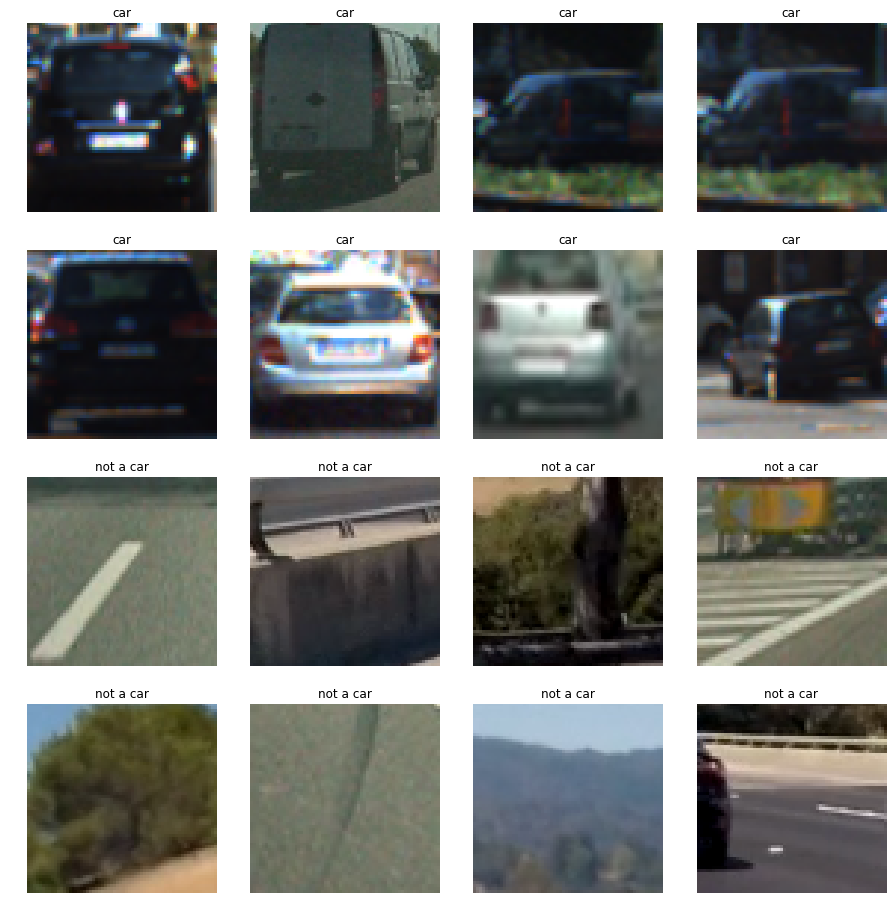

In [3]:
%matplotlib inline

fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(8):
    img = cv2.imread(images_car[np.random.randint(0,len(images_car))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)
    axs[i].imshow(img)
for i in range(8,16):
    img = cv2.imread(images_noncar[np.random.randint(0,len(images_noncar))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not a car', fontsize=12)
    axs[i].imshow(img)

### Extracting color and hog features

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0, 256))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_image(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    
    image = np.copy(img) 
    
    features = []
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
    if hist_feat == True:
            # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0, 256))
        
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
    return np.concatenate((spatial_features, hist_features, hog_features))

## extract test image for data set

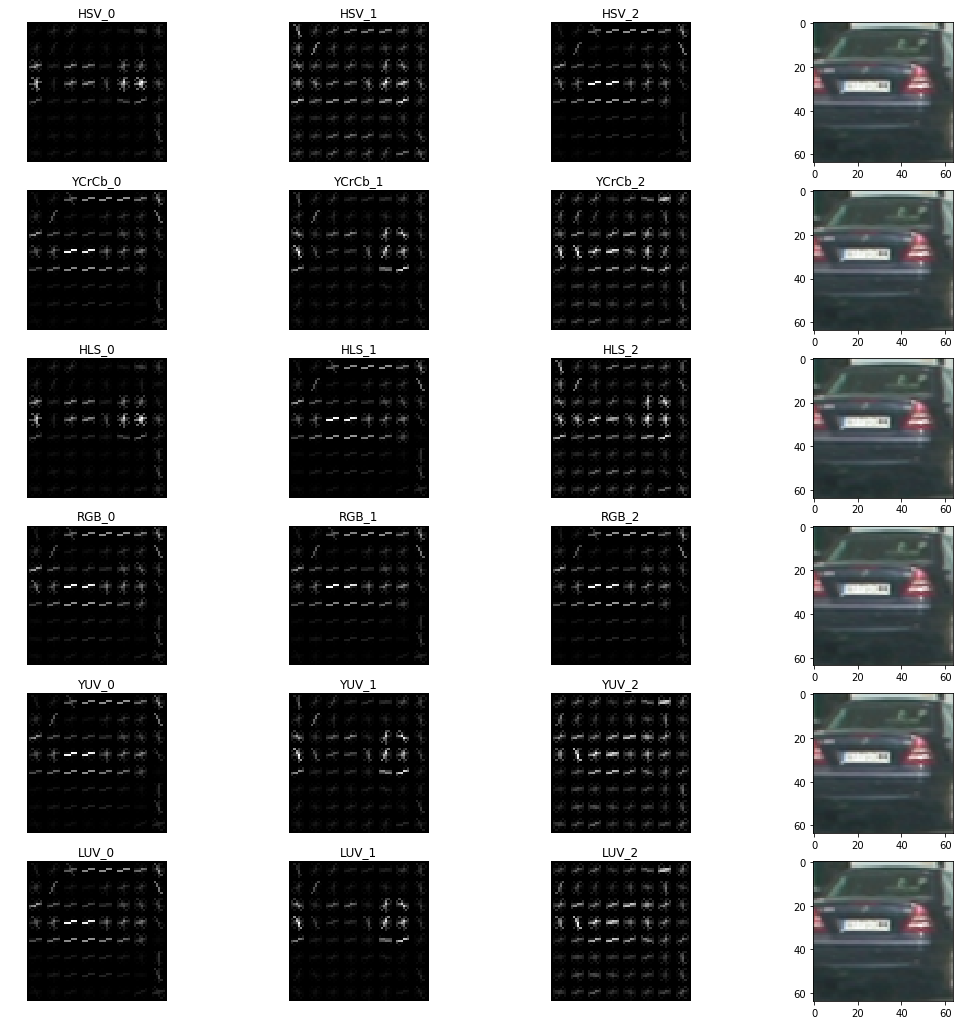

In [8]:
car_img = mpimg.imread(images_car[1000])

fig, axs = plt.subplots(6,4, figsize=(18, 18))

axs = axs.ravel()

color_space_dict = {'HSV':cv2.COLOR_RGB2HSV,  'LUV': cv2.COLOR_RGB2LUV, 
                    'HLS':cv2.COLOR_RGB2HLS,  'YUV': cv2.COLOR_RGB2YUV,
                    'YCrCb':cv2.COLOR_RGB2YCrCb, 'RGB': 0}
count = 0
for i in color_space_dict:
    if i is not 'RGB':
        feature_image = cv2.cvtColor(car_img, color_space_dict[i])
    else:
        feature_image = car_img
    for j in range(4):
        
        if j < 3:
            _, car_dst = get_hog_features(feature_image[:,:,j], 9, 8, 8, vis=True, feature_vec=True)
            axs[count].axis('off')
            axs[count].set_title(i+'_'+str(j), fontsize=12)
            axs[count].imshow(car_dst, cmap='gray')
        else:
            axs[count].imshow(car_img)

        count += 1
    

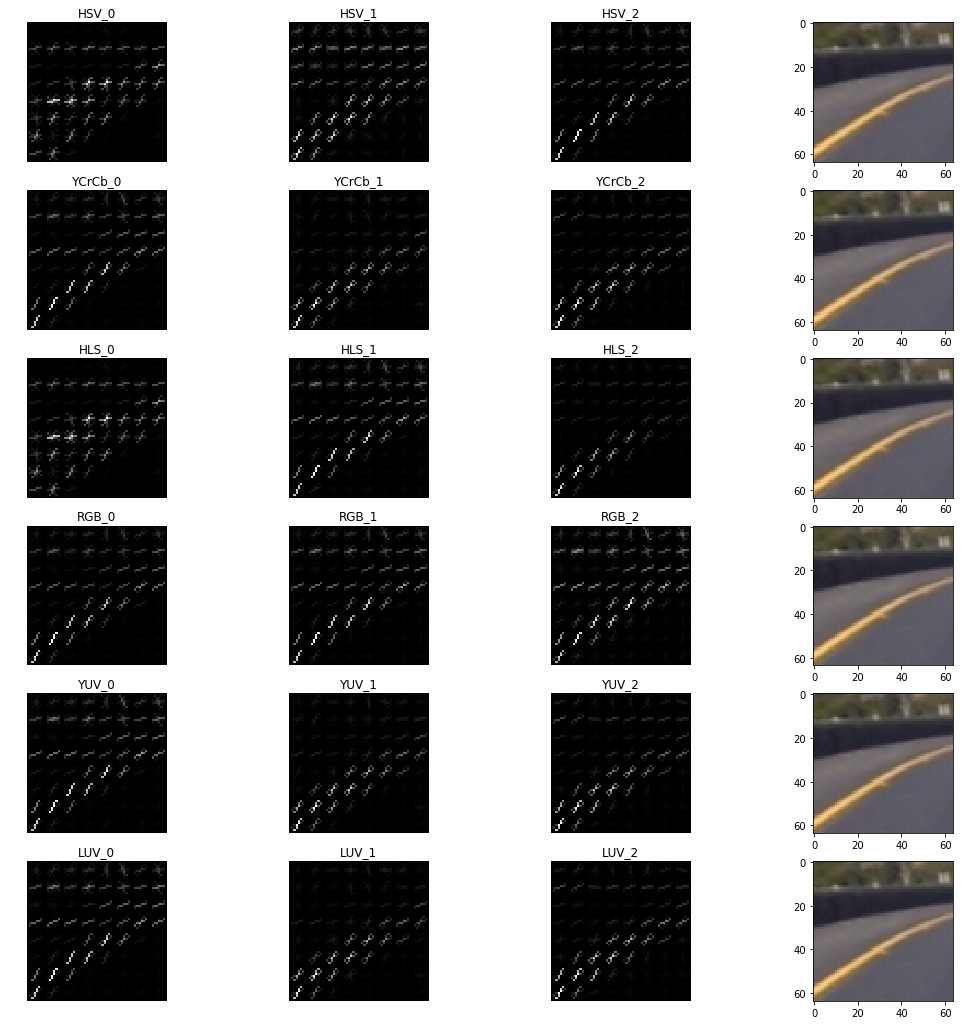

In [9]:
noncar_img = mpimg.imread(images_noncar[5])

fig, axs = plt.subplots(6,4, figsize=(18, 18))

axs = axs.ravel()

color_space_dict = {'HSV':cv2.COLOR_RGB2HSV,  'LUV': cv2.COLOR_RGB2LUV, 
               'HLS':cv2.COLOR_RGB2HLS,  'YUV': cv2.COLOR_RGB2YUV,
               'YCrCb':cv2.COLOR_RGB2YCrCb, 'RGB': 0}
count = 0
for i in color_space_dict:
    if i is not 'RGB':
        feature_image = cv2.cvtColor(noncar_img, color_space_dict[i])
    else:
        feature_image = noncar_img
    for j in range(4):
        
        if j < 3:
            _, car_dst = get_hog_features(feature_image[:,:,j], 9, 8, 8, vis=True, feature_vec=True)
            axs[count].axis('off')
            axs[count].set_title(i+'_'+str(j), fontsize=12)
            axs[count].imshow(car_dst, cmap='gray')
        else:
            axs[count].imshow(noncar_img)

        count += 1

### Model tuning ans training

In [10]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(images_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(images_noncar, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

Using: 8 orientations 8 pixels per cell and 2 cells per block


In [11]:
t = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

4.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


In [62]:
decision_non_car = svc.decision_function(X_train[y_train == 0])
print("average of decision of non car images," + str(np.mean(decision_non_car)))

decision_car = svc.decision_function(X_train[y_train == 1])

print("average of decision of car images," + str(np.mean(decision_car)))

average of decision of non car images,-3.10719942836
average of decision of car images,3.21513602451


## Sliding window

In [173]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list    
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, xy_window = (64, 64), xy_overlap = (0.6, 0.6), decision_th = 0.8, debug = False):

    img = img.astype(np.float32)/255
    
    windows = slide_window(img, [xstart, xstop], [ystart ,ystop], xy_window, xy_overlap)
    
    if debug:
        noncar_dec = []
        car_dec = []
    
    rectangles = []
    
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        features = extract_features_image(img_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        
        scaled_features = scaler.transform(features.reshape(1, -1))
        
        pred = svc.predict(scaled_features)
        dec_b = svc.decision_function(scaled_features)
        
        if debug:
            if pred == 1 and window[1][0] < 600:
                noncar_dec.append(dec_b)
            if pred == 1 and window[1][0] >= 600:
                car_dec.append(dec_b)
                
        if pred == 1 and dec_b >= decision_th:
            rectangles.append(window)
            if debug:
                print(noncar_dec)
    
    if debug:
        if len(noncar_dec) > 0:
            print("noncar ", min(noncar_dec), sum(noncar_dec)/len(noncar_dec) , max(noncar_dec))
        if len(car_dec) > 0:
            print("car ",min(car_dec), sum(car_dec)/len(car_dec) , max(car_dec))
        
    return rectangles
                

In [155]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

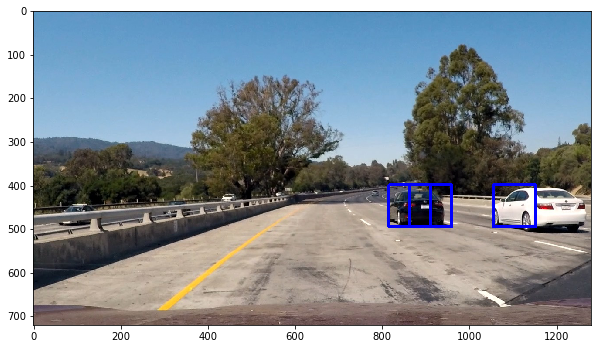

In [156]:
img = mpimg.imread('.\\test_images\\test1.jpg')

ystart = 350
ystop = 700

color_space = 'YCrCb'
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
scale = 1.5
xy_window = (int(64*scale), int(64*scale))
xy_overlap = (0.5, 0.5)

    
rect = find_cars(img, None, None, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
                 cell_per_block, spatial_size, hist_bins, xy_window, xy_overlap)

out_img = draw_boxes(img, rect)

plt.figure(figsize=(10,10))

plt.imshow(out_img)

In [181]:
def draw_searching_range(img, m_scale):

    rectangles = []
    
    xy_overlap = (0.5, 0.5)
    
    
    ystart = 390
    ystop = ystart + 64
    
    y_origin_start = ystart
    yend = 760
    scale = 1.0
    y_windows = 64
    gap = 16
    xy_window = (int(64*scale), int(64*scale))
    counter = 0
    
    x_start =  None if img.shape[1]%int(y_windows//2) == 0 else img.shape[1]%int(y_windows//2)
    
    draw_img = np.copy(img)
    
    while(ystop < yend):
        
        y_start_stop = [ystart, ystop]
        
        if (scale == m_scale):
            rect = slide_window(img, x_start_stop=[x_start, None], y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=xy_overlap)
            rectangles.append(rect)
        
        
        if(counter%2 == 0):
            ystart = y_origin_start + int((counter/2 + 1)*gap)
        else:
            ystart = y_origin_start
            
        scale = scale + 0.5*(counter%2)
        
        y_windows = int(64*scale)
        ystop = ystart + y_windows
        xy_window = (int(64*scale), int(64*scale))
        
        x_start =  None if img.shape[1]%int(y_windows//2) == 0 else img.shape[1]%int(y_windows//2)
        counter += 1
    
    
    car_rect = []
    for r in rectangles:
        for i in r:
            car_rect.append(i)
    
    thick = 2
    r = 0
    for bbox in car_rect:
        color = (r , 0 ,255)
        r += 2
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    
    return draw_img

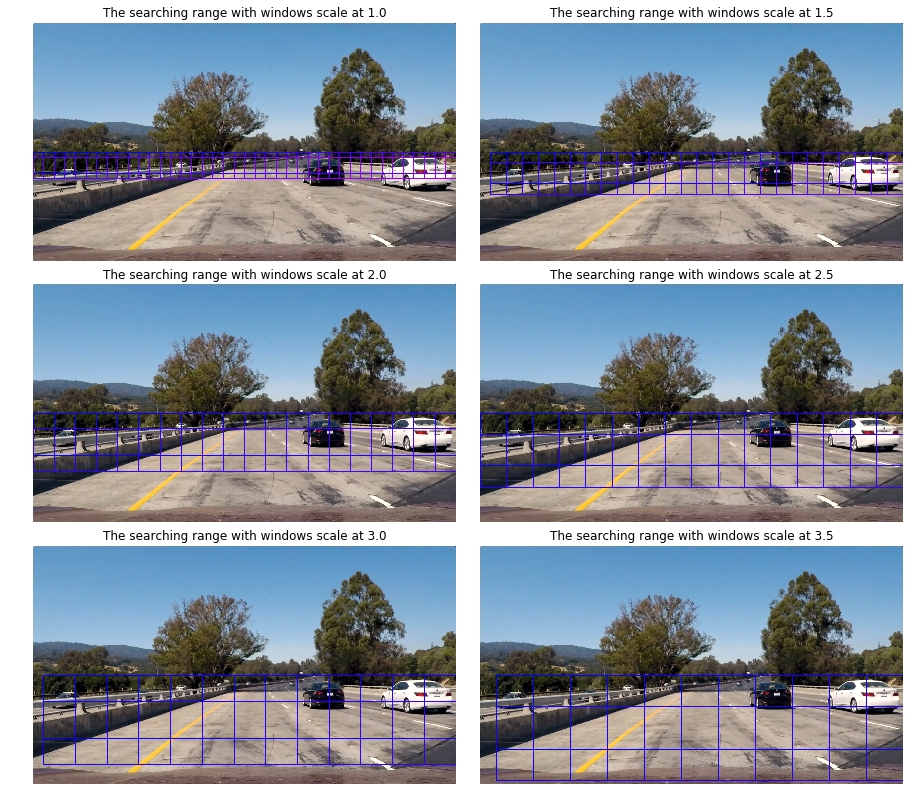

In [182]:
img = mpimg.imread('.\\test_images\\test1.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .1, wspace=.002)
axs = axs.ravel()

scale = 1.0

for i in range(6):
    axs[i].imshow(draw_searching_range(img , scale))
    axs[i].axis('off')
    axs[i].set_title("The searching range with windows scale at " + str(scale))
    scale += 0.5

In [159]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## car detection pipeline

In [160]:
def car_detection(img, heat_map = False):

    rectangles = []

    color_space = 'YCrCb'
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    
    xy_overlap = (0.5, 0.5)
    
    
    ystart = 400
    ystop = 464
    
    y_origin_start = ystart
    yend = 760
    
    scale = 1.0
    y_windows = 64
    gap = 16
    xy_window = (int(64*scale), int(64*scale))
    counter = 0
    
    
    while(ystop < yend):
        
        rect = find_cars(img, None, None, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
                 cell_per_block, spatial_size, hist_bins, xy_window, xy_overlap)
        
        rectangles.append(rect)
        
        
        if(counter%2 == 0):
            ystart = y_origin_start + int((counter/2 + 1)*gap)
        else:
            ystart = y_origin_start
            
        scale = scale + 0.5*(counter%2)
        y_windows = int(64*scale)
        ystop = ystart + y_windows
        xy_window = (int(64*scale), int(64*scale))
        counter += 1
    
    
    car_rect = []
    for r in rectangles:
        for i in r:
            car_rect.append(i)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, car_rect)
    heatmap_img = apply_threshold(heatmap_img, 1)
    if heat_map == True:
        return heatmap_img
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

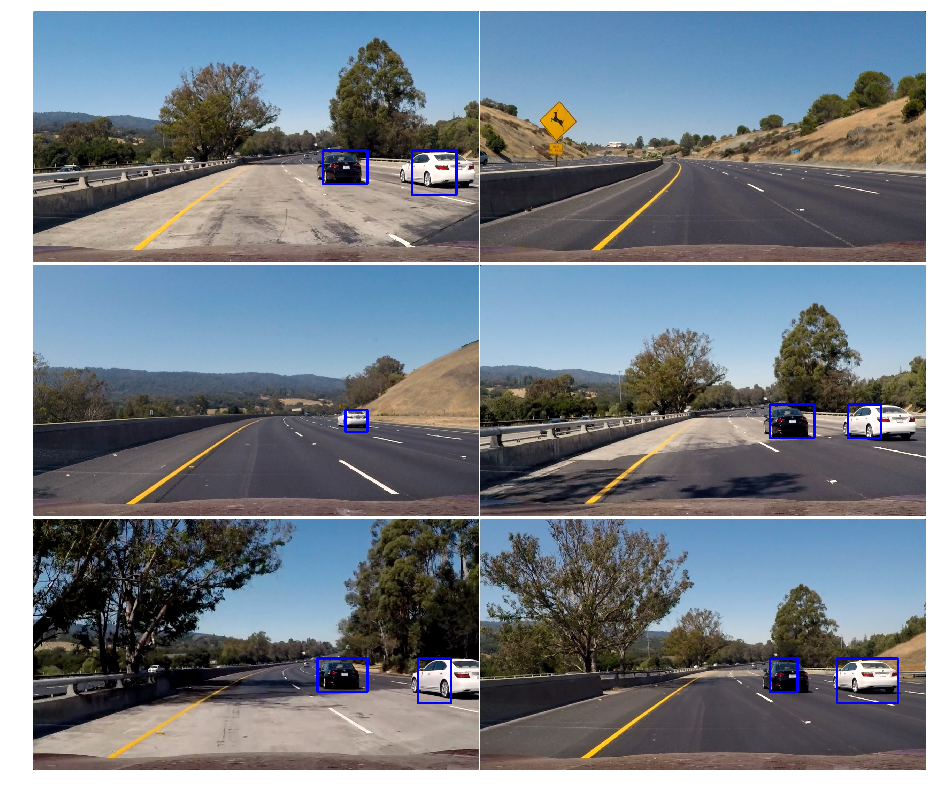

In [161]:
test_images = glob.glob('.\\test_images\\*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, p in enumerate(test_images):
    axs[i].imshow(car_detection(mpimg.imread(p)))
    axs[i].axis('off')

## heat map

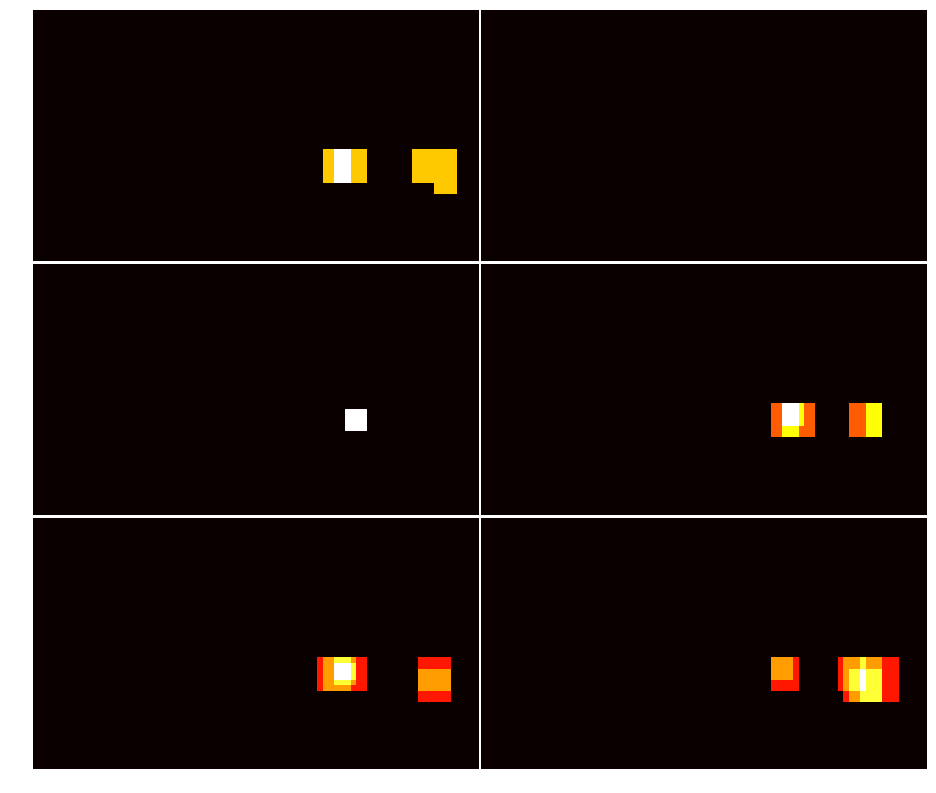

In [162]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, p in enumerate(test_images):
    axs[i].imshow(car_detection(mpimg.imread(p), True), cmap='hot')
    axs[i].axis('off')

## Labels to Heatmap

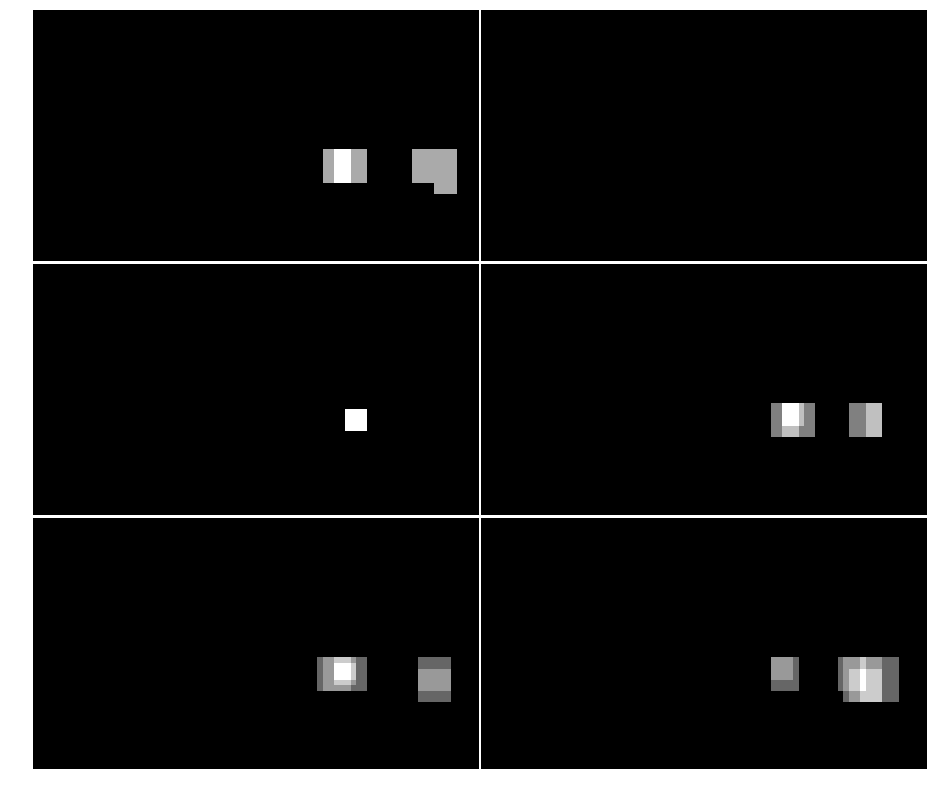

In [163]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, p in enumerate(test_images):
    axs[i].imshow(car_detection(mpimg.imread(p), True), cmap='gray')
    axs[i].axis('off')

In [165]:
from moviepy.editor import VideoFileClip

test_out_file = 'project5_test_video.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(car_detection)
%time clip_test_out.write_videofile(test_out_file, audio=False)

clip_test.reader.close()
clip_test.audio.reader.close_proc()

[MoviePy] >>>> Building video project5_test_video.mp4
[MoviePy] Writing video project5_test_video.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:30<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_test_video.mp4 

Wall time: 30.8 s


In [166]:
test_out_file = 'project5_video.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(car_detection)
%time clip_test_out.write_videofile(test_out_file, audio=False)

clip_test.reader.close()
clip_test.audio.reader.close_proc()

[MoviePy] >>>> Building video project5_video.mp4
[MoviePy] Writing video project5_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [16:50<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_video.mp4 

Wall time: 16min 50s


## car detection pipeline v2

In [187]:
def car_detection_v2(img):

    car_rects = []
    
    global keep_frames
    global decision_th
    global threshold
    global keep_size
    global debug
    
    color_space = 'YCrCb'
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    
    xy_overlap = (0.5, 0.5)
    
    ystart = 395
    ystop = ystart + 64
    
    y_origin_start = ystart
    yend = 760
    
    scale = 1.0
    y_windows = 64
    gap = 16
    xy_window = (int(64*scale), int(64*scale))
    counter = 0
    
    x_start =  None if img.shape[1]%int(y_windows//2) == 0 else img.shape[1]%int(y_windows//2)
    
    while(ystop < yend):
        
        rect = find_cars(img, x_start, None, ystart, ystop, svc, X_scaler, orient, pix_per_cell, 
                 cell_per_block, spatial_size, hist_bins, xy_window, xy_overlap, decision_th, debug)
        
        car_rects.append(rect)
        
        if(counter%2 == 0):
            ystart = y_origin_start + int((counter/2 + 1)*gap)
        else:
            ystart = y_origin_start
            
        scale = scale + 0.5*(counter%2)
        y_windows = int(64*scale)
        ystop = ystart + y_windows
        xy_window = (int(64*scale), int(64*scale))
        
        x_start =  None if img.shape[1]%int(y_windows//2) == 0 else img.shape[1]%int(y_windows//2)
        
        counter += 1
    
    cars_box = []
    for r in car_rects:
        for i in r:
            cars_box.append(i)
    
    heatmap_img = np.zeros_like(img[:,:,0])

    keep_frames.append(cars_box)
    
    if(len(keep_frames) > keep_size):
        keep_frames.pop(0)

    for f in keep_frames:
        heatmap_img = add_heat(heatmap_img, f)
        
    #heatmap_img = apply_threshold(heatmap_img, 1 + keep_size//2)
    heatmap_img = apply_threshold(heatmap_img, threshold)
    
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [188]:
keep_frames = []
decision_th = 0.76
keep_size = 10
threshold = 10//2
debug = False

test_out_file = 'project5_video_v2.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(car_detection_v2)
%time clip_test_out.write_videofile(test_out_file, audio=False)

clip_test.reader.close()
clip_test.audio.reader.close_proc()

[MoviePy] >>>> Building video project5_video_v2.mp4
[MoviePy] Writing video project5_video_v2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:12<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_video_v2.mp4 

Wall time: 17min 12s


In [189]:
keep_frames = []
decision_th = 0.76
keep_size = 10
threshold = 10//2

debug = False

test_out_file = 'project5_test_video_v2.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(car_detection_v2)
%time clip_test_out.write_videofile(test_out_file, audio=False)

clip_test.reader.close()
clip_test.audio.reader.close_proc()

[MoviePy] >>>> Building video project5_test_video_v2.mp4
[MoviePy] Writing video project5_test_video_v2.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:30<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_test_video_v2.mp4 

Wall time: 31 s


In [186]:
joblib.dump(svc, 'model.pkl') 

['model.pkl']